In [50]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def get_raw_pixels(full_data=True):
    df = pd.read_csv('data/processed_nist_data.csv', sep=',', header=None)
    if full_data:
        df = df.as_matrix()
        X, y = df[:, 1:], df[:, 0]
        X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.8, shuffle=True)
    else:
        df = df.sample(frac=1).reset_index(drop=True)  # shuffle data
        df = df.groupby(0)
        df100 = df.apply(lambda x: x.sample(frac=0.01)).as_matrix()
        X_train, y_train = df100[:, 1:], df100[:, 0]
        df1000 = df.apply(lambda x: x.sample(frac=0.1)).as_matrix()
        X_validate, y_validate = df1000[:, 1:], df1000[:, 0]
        
    return X_train, X_validate, y_train, y_validate


def experimentPCA_fulldata(classifier, full_data=True, filename=None, show_results=False, n_comp_auto=False):
    performance = {}
    
    if full_data:
        X_train, X_validate, y_train, y_validate = get_raw_pixels(full_data=True)
    else:
        X_train, X_validate, y_train, y_validate = get_raw_pixels(full_data=False)

    if not n_comp_auto:
        for n_comp in range(1, 30):
            print("processing c=", n_comp)
            pca = PCA(n_components=n_comp)
            classifier.fit(pca.fit_transform(X_train), y_train)
            performance[n_comp] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate))) * 100
        handle_plot(performance, show_results, filename)
    else:
        pca = PCA()
        pca.fit(X_train)
        variance = pca.explained_variance_
        n_comp = max(np.argwhere(variance > 0.9))[0]
        pca.n_components = n_comp
        classifier.fit(pca.fit_transform(X_train), y_train)
        performance[0] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate))) * 100

    return performance, n_comp


def handle_plot(performance, show_results, filename):
    fig = plt.figure()
    plt.title('Number of Components Retained vs Performance')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy (%)')

    plt.plot(performance.keys(), performance.values())
    if show_results:
        plt.show()
    if filename:
        pp = PdfPages("experiment-results/" + filename + ".pdf")
        pp.savefig(fig)
        pp.close()

In [51]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import pr_utils

mlp = MLPClassifier(hidden_layer_sizes=(330, 85), max_iter=150, alpha=1e-5,
                    solver='lbfgs', tol=1e-4, random_state=1,
                    learning_rate_init=.1)

experimentPCA_fulldata(mlp, full_data=False, filename="NN_330_85_batch", show_results=True, n_comp_auto=True)

({0: 84.399999999999991}, 33)

(5,)
(10,)
(10, 5)


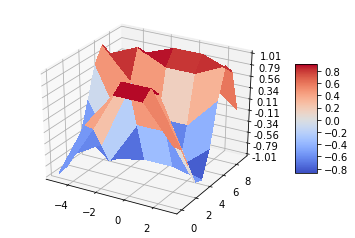

In [52]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 2)
Y = np.arange(0, 10, 1)
print(X.shape)
print(Y.shape)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


def plot3d(X, Y, Z, name=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Make data.
    # X = np.arange(-5, 5, 2)
    # Y = np.arange(0, 10, 1)
    print(X.shape)
    print(Y.shape)
    X, Y = np.meshgrid(X, Y)
    # R = np.sqrt(X**2 + Y**2)
    # Z = np.sin(R)
    print(Z.shape)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(Z.min(), Z.max())
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if name:
        plt.savefig("experiment-results/" + name + ".png", dpi=400)
    plt.show()

In [71]:
import numpy as np
from sklearn import metrics
from sklearn.neural_network import MLPClassifier


def tune_layer_size(X_train, y_train, X_test, y_test):
    layer1_step = 2
    layer2_step = 2
    layer1_start = 20
    layer1_stop = 90
    layer2_start = 11
    layer2_stop = 60

    results = {}
    layer2_index = 0
    layer1_index = 0
    res_layer2 = np.arange(layer2_start, layer2_stop, layer2_step)
    res_layer1 = np.arange(layer1_start, layer1_stop, layer1_step)
    res = np.zeros((res_layer2.shape[0], res_layer1.shape[0]))

    for layer2 in range(layer2_start, layer2_stop, layer2_step):
        layer1_index = 0
        for layer1 in range(layer1_start, layer1_stop, layer1_step):
            mlp = MLPClassifier(hidden_layer_sizes=(layer1, layer2), max_iter=150, alpha=1e-5,
                                solver='lbfgs', tol=1e-4, random_state=1,
                                learning_rate_init=.1)
            
            acc, com = experimentPCA_fulldata(mlp, full_data=False, filename="NN_330_85_batch", show_results=True, n_comp_auto=True)
            acc = acc[0]
            # mlp.fit(X_train, y_train)
            # acc = metrics.accuracy_score(y_test, mlp.predict(X_test))
            # acc = np.random.rand()*10

            results[(layer1, layer2)] = acc
            res[layer2_index][layer1_index] = acc
            
            layer1_index += 1
        layer2_index += 1
        print("progress", (((layer2 - layer2_start) / layer2_step) + 1) / ((layer2_stop - layer2_start) / layer2_step))

    max_key = max(results.keys(), key=(lambda key: results[key]))
    # print(max_key)
    # print(results.get(max_key))

    # return results, max_key, results.get(max_key)
    return res_layer1, res_layer2, res, results

In [73]:
import pr_utils

X_train, y_train = pr_utils.get_train_dataset_100()
X_validate, y_validate = pr_utils.get_test_dataset_1000()
X, Y, Z, total_results = tune_layer_size(X_train, y_train, X_validate, y_validate)

print(X.shape, Y.shape, Z.shape)

progress 0.04081632653061224


progress 0.08163265306122448


progress 0.12244897959183673


progress 0.16326530612244897


progress 0.20408163265306123


progress 0.24489795918367346


progress 0.2857142857142857


progress 0.32653061224489793


progress 0.3673469387755102


progress 0.40816326530612246


progress 0.4489795918367347


progress 0.4897959183673469


progress 0.5306122448979592


progress 0.5714285714285714


progress 0.6122448979591837


progress 0.6530612244897959


progress 0.6938775510204082


progress 0.7346938775510204


progress 0.7755102040816326


progress 0.8163265306122449


progress 0.8571428571428571


progress 0.8979591836734694


progress 0.9387755102040817


progress 0.9795918367346939


progress 1.0204081632653061
(35,) (25,) (25, 35)


(35,)
(25,)
(25, 35)


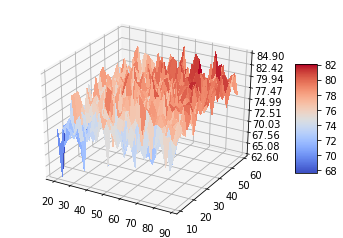

(76, 57)
84.9


In [74]:
plot3d(X, Y, Z, name="nn_layers_batch_pca")
max_key = max(total_results.keys(), key=(lambda key: total_results[key]))
print(max_key)
print(total_results.get(max_key))